Configuración Parametros Problema Optimización



In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import levy

In [2]:
dim = 2  # Dimensiones del problema (2D)
campo_dim = (100, 100)
inicio = np.array([10, 10])
objetivo = np.array([90, 90])

# Obstáculos (rectángulos)
arboles = [
    ((20, 20), (30, 30)),  # Lago 1
    ((50, 50), (60, 60)),  # Lago 2
    ((40, 70), (45, 75)),  # Árbol 1
    ((70, 20), (80, 30)),  # Árbol 2
    ((60, 80), (70, 90))   # Árbol 3
]

GSIS

In [4]:


# ----------------------------- CONFIGURACIÓN BÁSICA ----------------------------- #

# Coeficiente de penalización por colisión
ALPHA = 1000

# Parámetros del GSIS
n_jugadores = 17
max_iteraciones = 300
precision = 0.1
pert_prob_delta = 0.002  # si es 0 se convierte en un greedy

# Inicializar población y variables globales de tracking
velocidades_iniciales = np.random.uniform(5, 100, n_jugadores)
# Cada jugador inicia en el mismo punto
poblacion_inicial = np.array([inicio for _ in range(n_jugadores)])


# -------------------- FUNCIONES PARA DETECTAR INTERSECCIÓN CON OBSTÁCULOS -------------------- #
def orient(a, b, c):
    return ((b[1] - a[1]) * (c[0] - b[0])) - ((b[0] - a[0]) * (c[1] - b[1]))

def en_rango(a, b, c):
    return (min(a[0], c[0]) <= b[0] <= max(a[0], c[0]) and
            min(a[1], c[1]) <= b[1] <= max(a[1], c[1]))

def intersecta_segmentos(p1, p2, q1, q2):
    o1 = orient(p1, p2, q1)
    o2 = orient(p1, p2, q2)
    o3 = orient(q1, q2, p1)
    o4 = orient(q1, q2, p2)

    if (o1 * o2 < 0) and (o3 * o4 < 0):
        return True

    if o1 == 0 and en_rango(p1, q1, p2):
        return True
    if o2 == 0 and en_rango(p1, q2, p2):
        return True
    if o3 == 0 and en_rango(q1, p1, q2):
        return True
    if o4 == 0 and en_rango(q1, p2, q2):
        return True

    return False

def is_inside_rect(p, rect):
    (x_min, y_min), (x_max, y_max) = rect
    return (x_min <= p[0] <= x_max) and (y_min <= p[1] <= y_max)

def intersecta_segmento_rect(Pi, Li, rect):
    (x_min, y_min), (x_max, y_max) = rect
    rect_edges = [
        ((x_min, y_min), (x_min, y_max)),
        ((x_min, y_max), (x_max, y_max)),
        ((x_max, y_max), (x_max, y_min)),
        ((x_max, y_min), (x_min, y_min))
    ]
    for (q1, q2) in rect_edges:
        if intersecta_segmentos(Pi, Li, q1, q2):
            return True
    return False

def colision_con_obstaculos(Pi, Li, arboles):
    """
    Devuelve True si el segmento Pi->Li intersecta (o está dentro) de algún obstáculo
    """
    for obst in arboles:
        # Ver si los extremos están dentro del rectángulo
        if is_inside_rect(Pi, obst) or is_inside_rect(Li, obst):
            return True
        # O si el segmento intersecta alguna arista
        if intersecta_segmento_rect(Pi, Li, obst):
            return True
    return False

# ---------------------------------------------------------------------------- #
#                  FUNCIONES AUXILIARES (ruleta, velocidad, fit...)            #
# ---------------------------------------------------------------------------- #

def calcular_distancia(p1, p2):
    """
    Calcula la distancia euclidiana entre dos puntos p1 y p2.
    """
    return np.linalg.norm(p2 - p1)


def evaluar_fitness_ruta(ruta, arboles, alpha=1000):
    """
    Calcula el coste de toda la trayectoria 'ruta':
      - Suma de distancias euclídeas entre puntos consecutivos
      - Penalización alpha por cada colisión en un segmento
    """
    dist_total = 0.0
    colisiones = 0

    for i in range(len(ruta) - 1):
        Pi = ruta[i]
        Pi_1 = ruta[i+1]
        dist_total += calcular_distancia(Pi, Pi_1)
        if colision_con_obstaculos(Pi, Pi_1, arboles):
            colisiones += 1

    # --- penalización si la ruta no termina en el objetivo ---
    objetivo = np.array([90, 90])
    # Mide la distancia del último punto al objetivo
    dist_al_objetivo = calcular_distancia(ruta[-1], objetivo)

    # Dar un peso a esta penalización para que sea significativa:
    dist_total += dist_al_objetivo * 100.0

    return dist_total + alpha * colisiones

def costo_a_fitness(costo):
    return 1.0 / (1.0 + costo)

def calcular_costos_poblacion(poblacion, rutas, arboles, alpha):
    """
    Dada la población (posiciones actuales) y sus rutas,
    calcula el costo de la ruta de cada individuo.
    """
    costos = []
    for i in range(len(poblacion)):
        cost = evaluar_fitness_ruta(rutas[i], arboles, alpha)
        costos.append(cost)
    return costos

def ruleta_seleccion_indices(poblacion, rutas, n_seleccion, arboles, alpha=1000):
    """
    Selección por ruleta basada en el fitness de la ruta completa de cada individuo.
    """
    costos = calcular_costos_poblacion(poblacion, rutas, arboles, alpha)
    fitnesses = [costo_a_fitness(c) for c in costos]

    suma_fitness = sum(fitnesses)
    if suma_fitness == 0:
        probabilidades = [1.0 / len(poblacion)] * len(poblacion)
    else:
        probabilidades = [f / suma_fitness for f in fitnesses]

    indices_seleccionados = []
    for _ in range(n_seleccion):
        r = random.random()
        acumulado = 0.0
        for idx, p in enumerate(probabilidades):
            acumulado += p
            if acumulado >= r:
                indices_seleccionados.append(idx)
                break

    return indices_seleccionados

def calcular_velocidad_Tait(distancia):
    if distancia > 50:
        return 9.601 * np.exp(0.0054 * distancia)
    else:
        return 53.7933 * np.arctan(0.0673 * distancia**0.46187)

def operador_cruce(Ui, Pi1, Pi2):
    p = np.random.rand()
    if p < 0.5:
        return np.where(np.random.rand(*Ui.shape) < 0.5, Ui,
                        np.where(np.random.rand(*Ui.shape) < 0.5, Pi1, Pi2))
    else:
        return Ui

def calcular_probabilidad_perturbacion(fe_actual, fe_max):
    return np.tan(pert_prob_delta * (np.exp(1 - fe_actual / fe_max) +
                                     np.exp(fe_actual / fe_max - 1)))

def beta_FE(FE, FE_max):
    if FE_max == 0:
        return 0.0
    frac = FE / FE_max
    if frac >= 1.0:
        frac = 0.999999
    val = 5.0 * (1 - frac) * frac * np.sin(1.0 / (1.0 - frac))
    return val

def compute_epsilon_L(FE, FE_max):
    b = beta_FE(FE, FE_max)
    scale = abs(b)
    eps_L = levy.rvs(loc=0, scale=scale)
    return eps_L

def reflejar(Pi, Pj):
    return 2.0 * Pj - Pi


# ---------------------------------------------------------------------------- #
#                     GSIS ALGORITHM                                           #
# ---------------------------------------------------------------------------- #
def gsis_algorithm(poblacion, velocidades_iniciales, max_iter, precision,
                   arboles, alpha=1000):
    n_jugadores = len(poblacion)
    mejor_global = None
    mejor_fitness = np.inf
    F = [] #calcular fitness
    V = [] #calcular distancia

    # Rutas: para cada individuo, iniciamos con [inicio]
    rutas = [[poblacion[i].copy()] for i in range(n_jugadores)]

    for iteracion in range(max_iter):
        # Calculamos costos de toda la población
        costos_actuales = calcular_costos_poblacion(poblacion, rutas, arboles, alpha)

        # Registrar el mejor fitness de la población en esta iteración
        mejor_fitness_actual = min(costos_actuales)
        F.append(mejor_fitness_actual)
        idx = np.argmin(costos_actuales)
        V.append(calcular_distancia(poblacion[idx], objetivo))

        for i, Pi in enumerate(poblacion):
            # Selección de un "modelo" (compañero)
            if np.random.rand() < 0.5:
                j = ruleta_seleccion_indices(poblacion, rutas, 1, arboles, alpha)[0]
            else:
                # El "mejor" actual (según costo mínimo)
                j = np.argmin(costos_actuales)

            Pj = poblacion[j]
            x_t_peak = np.linalg.norm(Pj - Pi)

            # Velocidad inicial o Tait
            if iteracion == 0:
                v0 = velocidades_iniciales[i]
            else:
                v0 = calcular_velocidad_Tait(x_t_peak)

            v0_perturbado = abs((1 + 3 * np.random.normal()) * v0)
            xt_ij = 3.0 / 2.0 * x_t_peak

            u1 = np.random.rand()
            epsilon_N = (np.random.normal(0, 1 - iteracion / max_iter)
                         if iteracion / max_iter <= 0.5 else 0)
            rb = 1 if np.random.rand() < 0.5 else 0

            # ----- Generar candidata Li ----- #
            if u1 < 0.1:
                # Direccion Pj -> Pi
                dist_pj_pi = np.linalg.norm(Pj - Pi)
                if dist_pj_pi == 0:
                    direccion = np.random.uniform(-1, 1, dim)
                else:
                    direccion = (Pj - Pi) / dist_pj_pi

                Li = Pi + xt_ij * direccion + rb * epsilon_N
            else:
                u2 = np.random.rand()
                if u2 < 0.5:
                    # Levy
                    epsilon_L = compute_epsilon_L(iteracion, max_iter)
                    refPi = reflejar(Pi, Pj)
                    dist_ref = np.linalg.norm(refPi - Pi)
                    if dist_ref == 0:
                        dir_ref = np.random.uniform(-1, 1, dim)
                    else:
                        dir_ref = (refPi - Pi) / dist_ref
                    Li = Pi + xt_ij * dir_ref + (1 - rb)*epsilon_L + rb*epsilon_N
                else:
                    # Reflejo
                    refPj = reflejar(Pj, Pi)
                    dist_ref = np.linalg.norm(Pj - refPj)
                    if dist_ref == 0:
                        dir_ref = np.random.uniform(-1, 1, dim)
                    else:
                        dir_ref = (Pj - refPj) / dist_ref
                    Li = Pi + xt_ij * dir_ref + rb * epsilon_N

            Li = np.clip(Li, 0, 100)

            # ----- Selección de la mejor "Ui" evitando colisiones del SEGMENTO Pi->Ui ----- #
            MAX_INTENTOS = 10
            Ui = None
            for _ in range(MAX_INTENTOS):
                p = np.random.rand()
                if p < 0.5:
                    candidata = Li
                else:
                    # Mezclar la posición actual Pi y Li
                    candidata = np.copy(Pi)
                    idx = np.random.choice(dim, size=dim // 2, replace=False)
                    candidata[idx] = Li[idx]

                # Verificamos colisión en el segmento Pi->candidata
                if not colision_con_obstaculos(Pi, candidata, arboles):
                    Ui = candidata
                    break

            if Ui is None:
                Ui = Pi.copy()

            # ----- Aceptación por criterio de trayectoria ----- #
            # 1) Creamos la ruta candidata
            ruta_actual = rutas[i]
            ruta_candidata = ruta_actual.copy()
            ruta_candidata.append(Ui)

            costo_actual = evaluar_fitness_ruta(ruta_actual, arboles, alpha)
            costo_candidato = evaluar_fitness_ruta(ruta_candidata, arboles, alpha)

            if costo_candidato < costo_actual:
                # Aceptamos el nuevo punto
                poblacion[i] = Ui
                rutas[i] = ruta_candidata
            else:
                # Perturbación estocástica
                if np.random.rand() < calcular_probabilidad_perturbacion(iteracion, max_iter):
                    poblacion[i] = Ui
                    rutas[i] = ruta_candidata
                else:
                    # Revertimos a Pi
                    pass

            # ----- Operador de cruce (entre Ui, Pi1, Pi2) ----- #
            Pi1 = poblacion[np.random.randint(0, n_jugadores)]
            Pi2 = poblacion[np.random.randint(0, n_jugadores)]
            Ci = operador_cruce(Ui, Pi1, Pi2)

            # Probar una candidata Vi evitando colisiones del segmento Ui->Vi
            Vi = None
            for _ in range(MAX_INTENTOS):
                p = np.random.rand()
                if p < 0.5:
                    candidata = Ci
                else:
                    candidata = np.copy(Ui)
                    idx = np.random.choice(dim, size=dim // 2, replace=False)
                    candidata[idx] = Ci[idx]

                # Verificar colisión del segmento Ui->candidata
                if not colision_con_obstaculos(Ui, candidata, arboles):
                    Vi = candidata
                    break
            if Vi is None:
                Vi = Ui.copy()

            # ----- Aceptación de Vi a la ruta ----- #
            ruta_actual2 = rutas[i]
            ruta_candidata2 = ruta_actual2.copy()
            ruta_candidata2.append(Vi)

            costo_candidato2 = evaluar_fitness_ruta(ruta_candidata2, arboles, alpha)
            # (El costo_actual que usamos aquí puede haberse actualizado si aceptamos Ui)
            costo_actual2 = evaluar_fitness_ruta(ruta_actual2, arboles, alpha)

            if costo_candidato2 < costo_actual2:
                poblacion[i] = Vi
                rutas[i] = ruta_candidata2

        # ---- Al final de la iteración, actualizar la info de mejor global ---- #
        # Recalcular costos (ya que las rutas pueden haber cambiado)
        fitness_all = np.array([
            evaluar_fitness_ruta(rutas[k], arboles, alpha)
            for k in range(n_jugadores)
        ])
        min_idx = np.argmin(fitness_all)
        if fitness_all[min_idx] < mejor_fitness:
            mejor_global = poblacion[min_idx].copy()
            mejor_fitness = fitness_all[min_idx]

        # ---- Criterio de parada por precisión ---- #
        if mejor_fitness < precision:
            print(f"Se alcanzó el objetivo en la iteración {iteracion + 1}")
            break

    return mejor_global, mejor_fitness, poblacion, rutas, min_idx, V, F


Ejecución GSIS

Mejor fitness obtenido: 145.88628686890524
Mejor posición (mejor_global): [90 90]


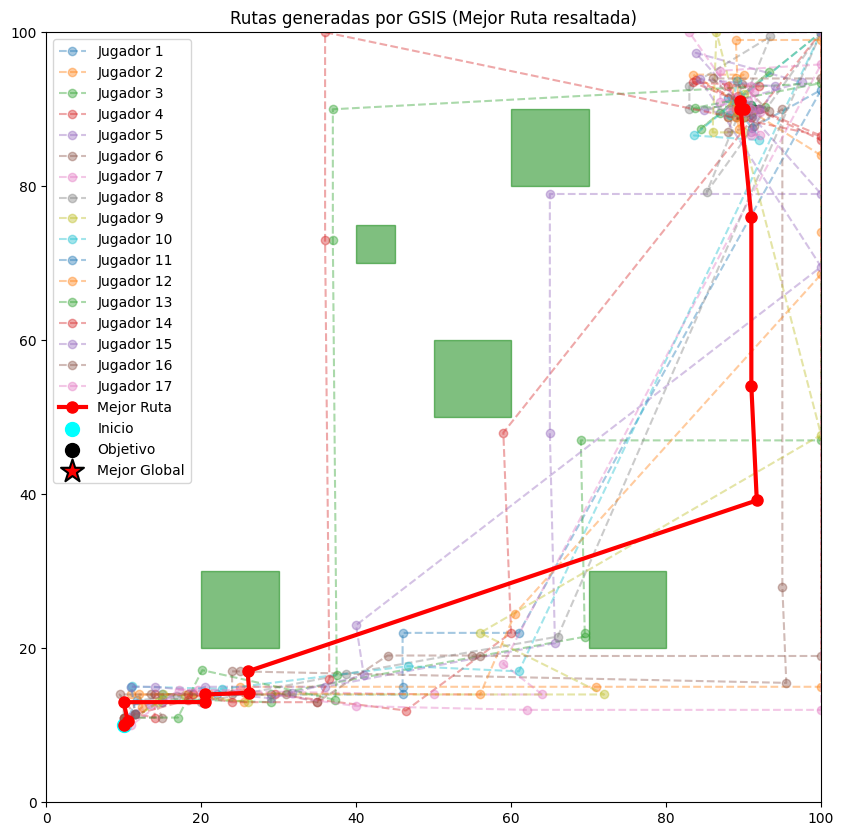

In [5]:

# ---------------------------------------------------------------------------- #
#                      EJECUCIÓN + VISUALIZACIÓN DEL RESULTADO                  #
# ---------------------------------------------------------------------------- #
mejor_global, mejor_fitness, poblacion_final, rutas_final, idx_mejor, gsis_V, gsis_F = gsis_algorithm(
    poblacion_inicial, velocidades_iniciales, max_iteraciones, precision,
    arboles, alpha=ALPHA
)

print("Mejor fitness obtenido:", mejor_fitness)
print("Mejor posición (mejor_global):", mejor_global)

# Visualización
plt.figure(figsize=(10, 10))
plt.xlim(0, campo_dim[0])
plt.ylim(0, campo_dim[1])

# Dibujar obstáculos
for (min_pos, max_pos) in arboles:
    plt.gca().add_patch(
        plt.Rectangle(min_pos,
                      max_pos[0] - min_pos[0],
                      max_pos[1] - min_pos[1],
                      color='green', alpha=0.5)
    )

# Dibujar rutas de TODOS los jugadores
for i, ruta in enumerate(rutas_final):
    ruta = np.array(ruta)
    if len(ruta) > 0:
        plt.plot(ruta[:, 0], ruta[:, 1], 'o--', label=f"Jugador {i+1}", alpha=0.4)

# Resaltar la MEJOR RUTA:
mejor_ruta = np.array(rutas_final[idx_mejor])
plt.plot(mejor_ruta[:, 0], mejor_ruta[:, 1],
         '-o', color='red', linewidth=3, markersize=8,
         label="Mejor Ruta")

# Dibujar inicio y objetivo
plt.scatter(*inicio, color='cyan', label="Inicio", s=100)
plt.scatter(*objetivo, color='black', label="Objetivo", s=100)

# Destacar el mejor global
plt.scatter(mejor_global[0], mejor_global[1],
            s=300, c='red', marker='*', edgecolors='k', linewidths=1.5,
            label='Mejor Global')

plt.legend()
plt.title("Rutas generadas por GSIS (Mejor Ruta resaltada)")
plt.show()

Recocido simulado

In [7]:
import numpy as np
import random
import math

# ------------------- FUNCIONES DEL PROBLEMA ------------------- #
def generar_vecino(ruta, campo_dim):
    """
    Genera un vecino modificando la ruta:
    - Añade un punto intermedio.
    - Mueve un punto existente.
    - Elimina un punto intermedio.
    """
    nuevo_ruta = ruta.copy()

    # Si la ruta solo tiene un punto, solo podemos añadir
    if len(nuevo_ruta) <= 1:
        opcion = "add"
    else:
        opcion = random.choice(["add", "move", "remove"])

    if opcion == "add" and len(nuevo_ruta) < 20:  # Limitar número de puntos intermedios
        # Añadir un nuevo punto intermedio en una posición aleatoria
        idx = random.randint(1, len(nuevo_ruta))  # Permite añadir al final de la lista
        nuevo_punto = np.random.uniform(0, campo_dim[0], size=2)
        nuevo_ruta.insert(idx, nuevo_punto)

    elif opcion == "move" and len(nuevo_ruta) > 1:
        # Mover un punto intermedio
        idx = random.randint(1, len(nuevo_ruta) - 1)  # No mover el punto inicial
        nuevo_ruta[idx] = np.random.uniform(0, campo_dim[0], size=2)

    elif opcion == "remove" and len(nuevo_ruta) > 2:
        # Eliminar un punto intermedio
        idx = random.randint(1, len(nuevo_ruta) - 1)  # No eliminar el punto inicial
        nuevo_ruta.pop(idx)

    return nuevo_ruta


def es_ruta_valida(ruta, arboles):
    """
    Comprueba si una ruta es válida (sin colisiones con obstáculos).
    """
    for i in range(len(ruta) - 1):
        if colision_con_obstaculos(ruta[i], ruta[i+1], arboles):
            return False
    return True

def evaluar_fitness_ruta_unificada(ruta, objetivo, arboles, alpha=1000, penalizacion_distancia=100.0):
    """
    Calcula el coste de toda la trayectoria 'ruta':
      - Suma de distancias euclídeas entre puntos consecutivos.
      - Penalización alpha por cada colisión en un segmento.
      - Penalización por distancia al objetivo.
    """
    dist_total = 0.0
    colisiones = 0

    for i in range(len(ruta) - 1):
        Pi = ruta[i]
        Pi_1 = ruta[i + 1]
        dist_total += calcular_distancia(Pi, Pi_1)
        if colision_con_obstaculos(Pi, Pi_1, arboles):
            colisiones += 1

    # Penalización por no llegar al objetivo
    dist_al_objetivo = calcular_distancia(ruta[-1], objetivo)
    dist_total += dist_al_objetivo * penalizacion_distancia

    return dist_total + alpha * colisiones



def visualizar_rutas(inicio, objetivo, dimensiones_campo, obstaculos, ruta):
    """
    Visualiza la ruta generada por el recocido simulado.
    """
    plt.figure(figsize=(10, 10))
    plt.xlim(0, dimensiones_campo[0])
    plt.ylim(0, dimensiones_campo[1])

    # Dibujar los obstáculos
    for (min_pos, max_pos) in obstaculos:
        plt.gca().add_patch(
            plt.Rectangle(min_pos,
                          max_pos[0] - min_pos[0],
                          max_pos[1] - min_pos[1],
                          color='green', alpha=0.5, label='Obstáculo' if 'Obstáculo' not in plt.gca().get_legend_handles_labels()[1] else "")
        )

    # Dibujar la ruta
    ruta = np.array(ruta)
    if len(ruta) > 0:
        plt.plot(ruta[:, 0], ruta[:, 1], 'o--', color='blue', label="Ruta Final")

    # Dibujar el inicio y el objetivo
    plt.scatter(*inicio, color='cyan', label="Inicio", s=100)
    plt.scatter(*objetivo, color='black', label="Objetivo", s=100)

    plt.legend()
    plt.title("Ruta generada")
    plt.show()

# ------------------- ALGORITMO DE RECOCIDO SIMULADO ------------------- #
def simulated_annealing_rutas(inicio, objetivo, campo_dim, arboles, T0=4075, alpha=0.98, max_iterations=3000, tol=0.1):
    """
    Implementación del algoritmo de recocido simulado adaptado al problema.
    """
    # Solución inicial: Una línea directa del inicio al objetivo
    solucion_actual = [inicio]
    mejor_solucion = solucion_actual
    mejor_costo = evaluar_fitness_ruta_unificada(solucion_actual,objetivo, arboles)
    T = T0
    F = [] #calcular fitness
    V = [] #calcular distancia

    for iteracion in range(max_iterations):
        #print(f"mejor:{mejor_solucion}")
        F.append(mejor_costo)
        # Generar vecino
        vecino = generar_vecino(solucion_actual, campo_dim)

        # Verificar que sea válido
        if not es_ruta_valida(vecino, arboles):
            continue

        # Evaluar costo del vecino
        costo_vecino = evaluar_fitness_ruta_unificada(vecino, objetivo, arboles)
        delta_costo = costo_vecino - mejor_costo

        # Decidir si se acepta el vecino
        if delta_costo < 0 or random.random() < math.exp(-delta_costo / T):
            solucion_actual = vecino
            if costo_vecino < mejor_costo:
                mejor_solucion = vecino
                mejor_costo = costo_vecino

        # Actualizar temperatura
        T *= alpha
        V.append(calcular_distancia(mejor_solucion[-1], objetivo))

        # Criterio de parada
        if mejor_costo < tol:
            print(f"Solución encontrada en la iteración {iteracion + 1}")
            break
        # Logging opcional
        if iteracion % 1000 == 0:
            print(f"Iteración {iteracion}: Mejor costo = {mejor_costo:.3f}, Temperatura = {T:.3f}")

    return mejor_solucion, mejor_costo, V, F


In [8]:
def estimate_T0(funcion_objetivo, generar_vecino, inicio, objetivo, campo_dim, arboles, p_worse=0.9, nsamples=1000):
    dfs = np.zeros(nsamples)
    samples = 0

    while samples < nsamples:
        # Generar una solución inicial y un vecino
        solucion_inicial = [inicio]
        vecino = generar_vecino(solucion_inicial, campo_dim)

        # Evaluar los costos
        costo_inicial = funcion_objetivo(solucion_inicial, objetivo, arboles)
        costo_vecino = funcion_objetivo(vecino, objetivo,arboles)

        # Registrar solo diferencias positivas (vecinos peores)
        if costo_vecino > costo_inicial:
            df = costo_vecino - costo_inicial
            dfs[samples] = df
            samples += 1

    # Calcular T0 basado en la mediana de las diferencias
    T0 = -np.median(dfs) / math.log(p_worse)
    return T0, dfs


In [23]:
# Estimar T0
T0, dfs = estimate_T0(evaluar_fitness_ruta_unificada, generar_vecino, inicio, objetivo, campo_dim, arboles)

print(f"Temperatura inicial estimada (T0): {T0}")

Temperatura inicial estimada (T0): 4075.5985446586833


Ejecucion Recocido Simulado

Iteración 2000: Mejor costo = 136.687, Temperatura = 0.000
136.6869350717795
[array([10, 10]), array([48.40304097, 28.84309622]), array([89.86067025, 90.1421972 ])]


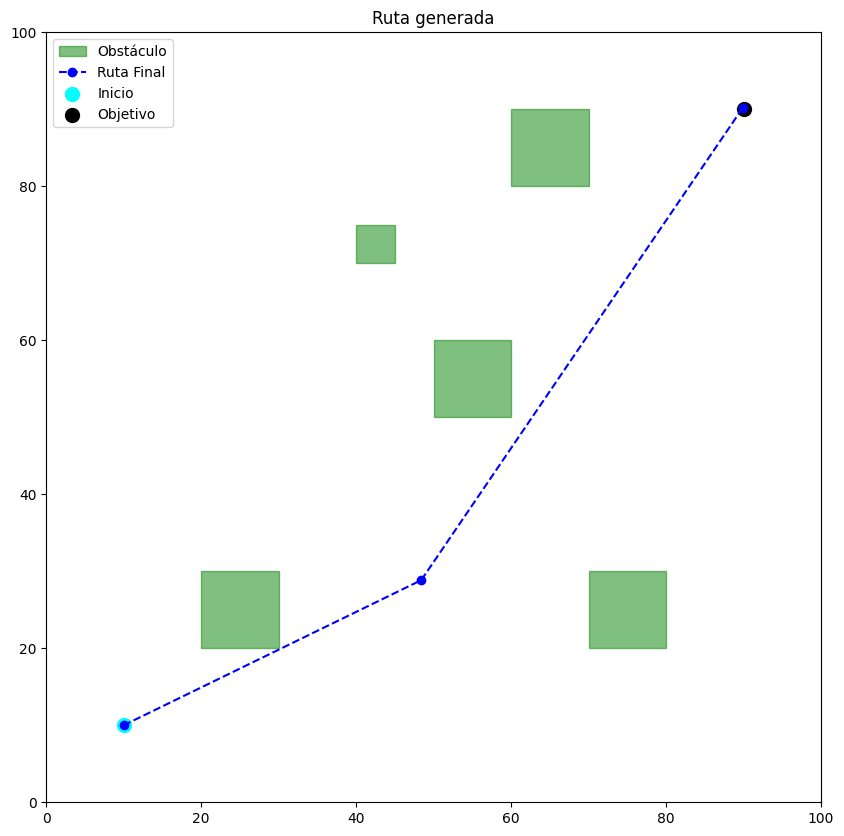

In [24]:
# Ejecutar recocido simulado
mejor_ruta, mejor_costo, sa_V, sa_F  = simulated_annealing_rutas(inicio, objetivo, campo_dim, arboles, T0=4075, alpha=0.98, max_iterations=3000, tol=0.1)
print(mejor_costo)
print(mejor_ruta)
# Visualizar la ruta final
visualizar_rutas(inicio, objetivo, campo_dim, arboles, mejor_ruta)


Búsqueda aleatoria

In [11]:
import numpy as np
import random

def random_search_rutas(inicio, objetivo, campo_dim, arboles, max_iter=1000):

    mejor_ruta = None
    mejor_costo = float('inf')
    rs_V = []  # Errores por iteración
    rs_F = []  # Fitness por iteración

    for iteracion in range(max_iter):
        # Generar una ruta aleatoria
        num_puntos = random.randint(2, 20)  # Número aleatorio de puntos intermedios (entre 2 y 20)
        puntos_intermedios = [
            np.random.uniform(0, campo_dim[0], size=2) for _ in range(num_puntos - 2)
        ]
        ruta_aleatoria = [inicio] + puntos_intermedios + [objetivo]

        # Verificar si la ruta es válida (sin colisiones)
        if not es_ruta_valida(ruta_aleatoria, arboles):
            continue

        # Evaluar el costo de la ruta
        costo_actual = evaluar_fitness_ruta(ruta_aleatoria, arboles)

        # Actualizar la mejor solución encontrada
        if costo_actual < mejor_costo:
            mejor_ruta = ruta_aleatoria
            mejor_costo = costo_actual

        # Registrar el error y el costo
        error_total = calcular_distancia(ruta_aleatoria[-1], objetivo)
        rs_V.append(error_total)
        rs_F.append(costo_actual)

        # Logging opcional
        if iteracion % 100 == 0:
            print(f"Iteración {iteracion}: Mejor costo = {mejor_costo:.3f}")

    return mejor_ruta, mejor_costo, rs_V, rs_F


Mejor ruta encontrada: [array([10, 10]), array([27.67857412, 52.3065733 ]), array([91.59414553, 93.31976927]), array([90, 90])]
Mejor costo encontrado: 125.47700844488374


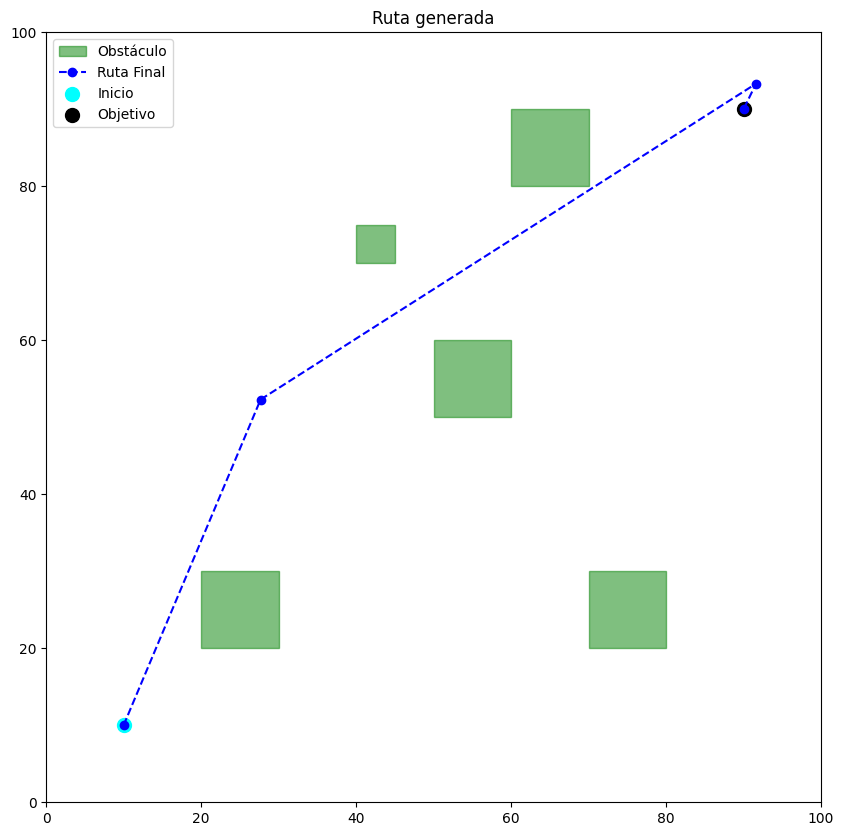

In [12]:
# Ejecutar el algoritmo aleatorio
mejor_ruta, mejor_costo, rs_V, rs_F = random_search_rutas(inicio, objetivo, campo_dim, arboles, max_iter=250)

# Imprimir resultados
print(f"Mejor ruta encontrada: {mejor_ruta}")
print(f"Mejor costo encontrado: {mejor_costo}")

# Visualizar la ruta final
visualizar_rutas(inicio, objetivo, campo_dim, arboles, mejor_ruta)

In [25]:
# Calcular diferencias de longitud entre las listas
diferencia_gsisV = len(sa_V) - len(gsis_V)
diferencia_gsisF = len(sa_F) - len(gsis_F)
diferencia_saV = len(gsis_V) - len(sa_V)
diferencia_saF = len(gsis_F) - len(sa_F)

diferencia_rsV = max(len(sa_V), len(gsis_V)) - len(rs_V)
diferencia_rsF = max(len(sa_F), len(gsis_F)) - len(rs_F)

# Rellenar gsis_V y gsis_F si son más cortos
if diferencia_gsisV > 0:
    gsis_V = np.pad(gsis_V, (0, diferencia_gsisV), mode='edge')

if diferencia_gsisF > 0:
    gsis_F = np.pad(gsis_F, (0, diferencia_gsisF), mode='edge')

# Rellenar sa_V y sa_F si son más cortos
if diferencia_saV > 0:
    sa_V = np.pad(sa_V, (0, diferencia_saV), mode='edge')

if diferencia_saF > 0:
    sa_F = np.pad(sa_F, (0, diferencia_saF), mode='edge')

# Rellenar rs_V y rs_F si son más cortos
if diferencia_rsV > 0:
    rs_V = np.pad(rs_V, (0, diferencia_rsV), mode='edge')

if diferencia_rsF > 0:
    rs_F = np.pad(rs_F, (0, diferencia_rsF), mode='edge')


Algorithm comparisons


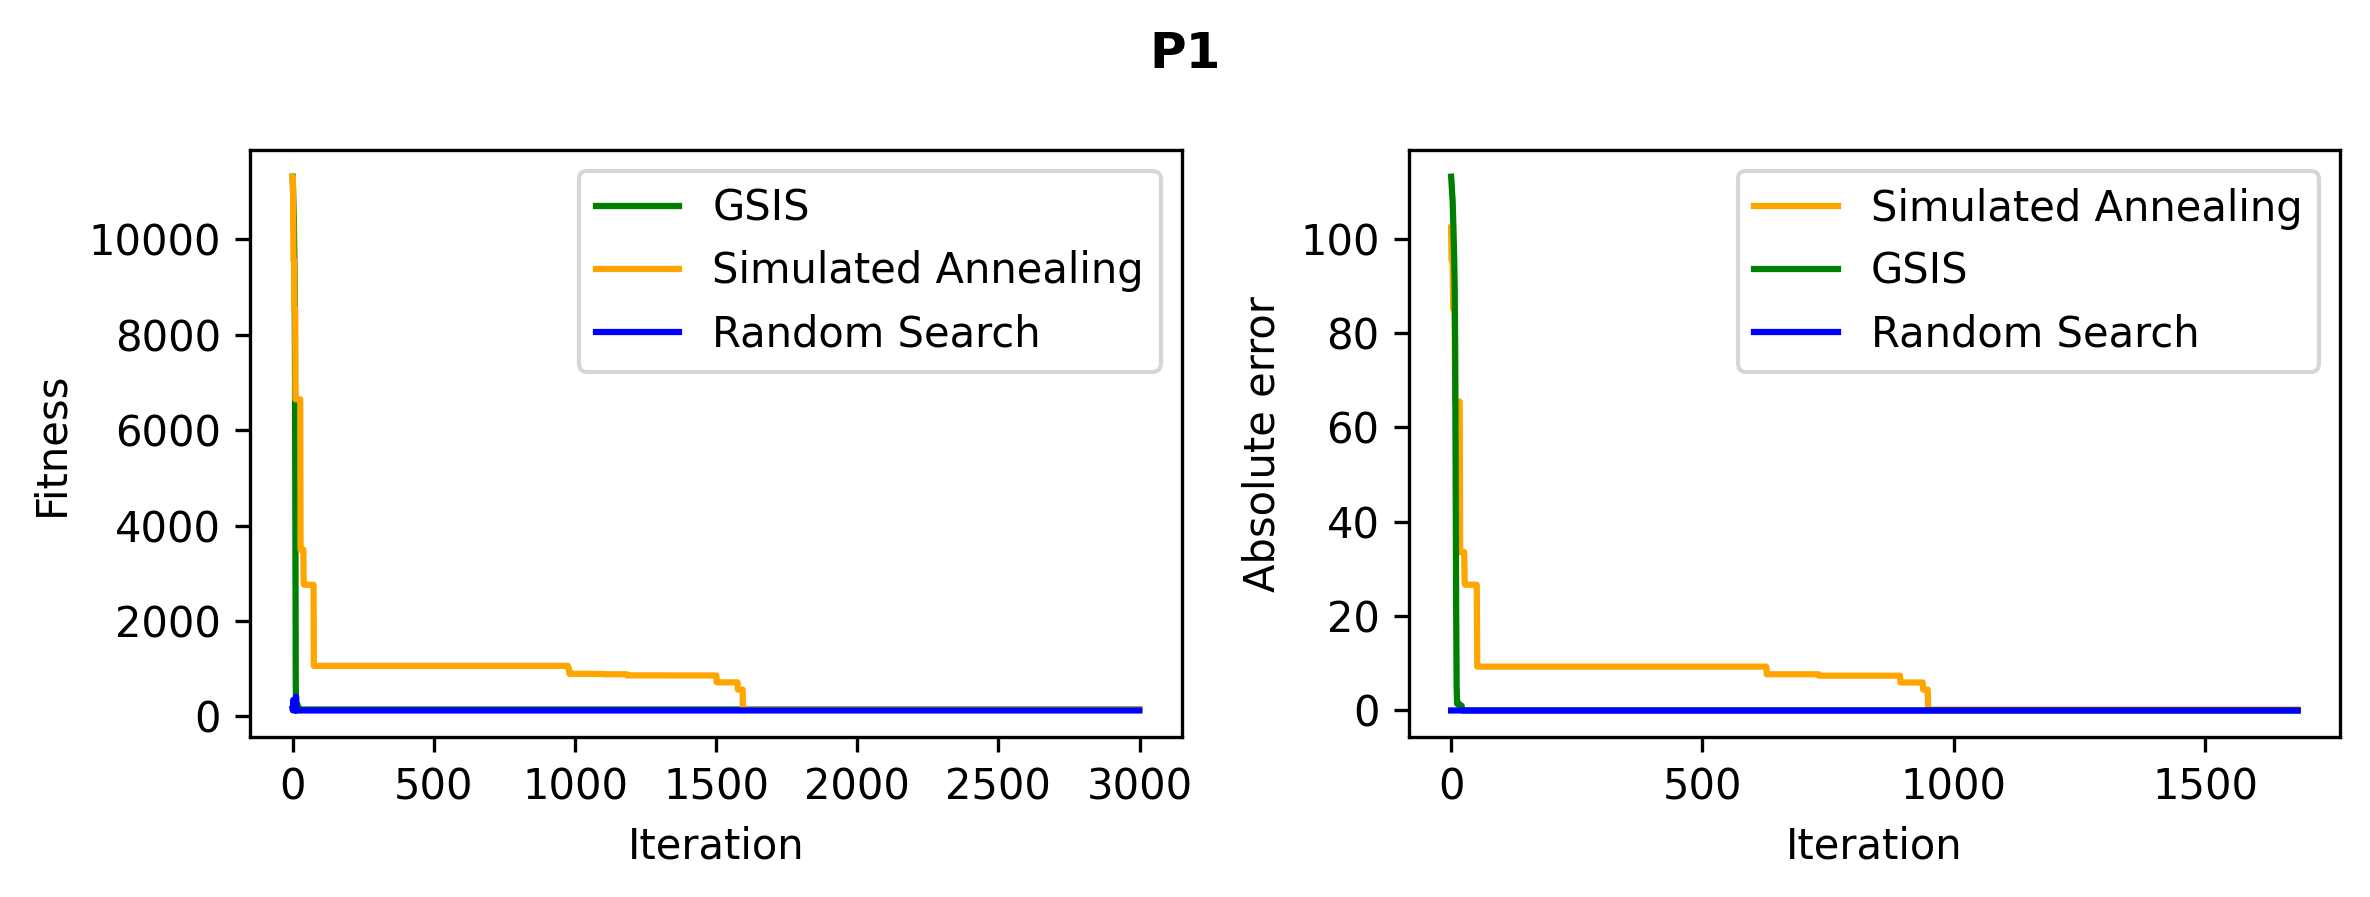

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

# Gráfico de Fitness
ax[0].plot(gsis_F, color='green', label='GSIS')
ax[0].plot(sa_F, color='orange', label='Simulated Annealing')
ax[0].plot(rs_F, color='blue', label='Random Search')

ax[0].set_ylabel('Fitness')
ax[0].set_xlabel('Iteration')

# Gráfico de Error Absoluto
ax[1].plot(sa_V, color='orange', label='Simulated Annealing')
ax[1].plot(gsis_V, color='green', label='GSIS')
ax[1].plot(rs_V, color='blue', label='Random Search')

ax[1].set_ylabel('Absolute error')
ax[1].set_xlabel('Iteration')

# Añadir leyendas y títulos
for a in ax:
    a.legend()

plt.suptitle("P1", fontweight='bold')
plt.tight_layout()
plt.show()

CONSTANTS

In [33]:
T0 = 4075
alpha = 0.98
tol = 0.1

In [34]:
import time
import pandas as pd

def calcular_distancia(p1, p2):
    """
    Calcula la distancia euclidiana entre dos puntos p1 y p2.
    """
    p1 = np.array(p1)
    p2 = np.array(p2)
    return np.linalg.norm(p2 - p1)

def measure_execution_time(func, *args, **kwargs):
    start_time = time.time()
    results = func(*args, **kwargs)
    end_time = time.time()
    execution_time = end_time - start_time
    return results, execution_time

def run_algorithms(N, inicio, objetivo, campo_dim, arboles, T0, alpha, tol):
    """
    Ejecuta GSIS, Simulated Annealing y Random Search N veces.
    """
    r_sa = []
    r_gsis = []
    r_rs = []

    for i in range(N):
        # Coeficiente de penalización por colisión
        ALPHA = 1000

        # Parámetros del GSIS
        n_jugadores = 17
        max_iteraciones = 300
        precision = 0.1
        pert_prob_delta = 0.002  # si es 0 se convierte en un greedy

        # Inicializar población y variables globales de tracking
        velocidades_iniciales = np.random.uniform(5, 100, n_jugadores)
        # Cada jugador inicia en el mismo punto
        poblacion_inicial = np.array([inicio for _ in range(n_jugadores)])

        # Ejecutar GSIS
        (mejor_global, mejor_fitness, poblacion_final, rutas_final, idx_mejor, gsis_V, gsis_F), gsis_time = measure_execution_time(
            gsis_algorithm, poblacion_inicial, velocidades_iniciales, max_iteraciones, precision, arboles, alpha=ALPHA
        )
        r_gsis.append({
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": gsis_time,
            "Iteraciones": len(gsis_F) - 1,
            "Mejor solución": rutas_final[idx_mejor],
            "Mejor fitness": mejor_fitness
        })

        # Ejecutar Simulated Annealing
        (mejor_ruta, mejor_costo, sa_V, sa_F), sa_time = measure_execution_time(
            simulated_annealing_rutas, inicio, objetivo, campo_dim, arboles
        )
        r_sa.append({
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": sa_time,
            "Iteraciones": len(sa_F) - 1,
            "Mejor solución": mejor_ruta,
            "Mejor fitness": mejor_costo
        })

        # Ejecutar Random Search
        (mejor_ruta_rs, mejor_costo_rs, rs_V, rs_F), rs_time = measure_execution_time(
            random_search_rutas, inicio, objetivo, campo_dim, arboles, max_iter=max_iteraciones
        )
        r_rs.append({
            "Ejecución": i + 1,
            "Tiempo de ejecución (s)": rs_time,
            "Iteraciones": len(rs_F) - 1,
            "Mejor solución": mejor_ruta_rs,
            "Mejor fitness": mejor_costo_rs
        })

    # Devolver los resultados como DataFrames
    return pd.DataFrame(r_gsis), pd.DataFrame(r_sa), pd.DataFrame(r_rs)


In [35]:
P1gsis_results, P1sa_results, P1rs_results = run_algorithms(10, inicio, objetivo, campo_dim, arboles, T0, alpha, tol)

Iteración 0: Mejor costo = 8949.561, Temperatura = 3433.920
Iteración 2000: Mejor costo = 195.363, Temperatura = 0.000
Iteración 100: Mejor costo = 118.343
Iteración 0: Mejor costo = 7320.873, Temperatura = 3433.920
Iteración 1000: Mejor costo = 525.269, Temperatura = 0.183
Iteración 200: Mejor costo = 119.797
Iteración 0: Mejor costo = 6483.160, Temperatura = 3433.920
Iteración 0: Mejor costo = 125.176
Iteración 0: Mejor costo = 9699.373, Temperatura = 3433.920
Iteración 2000: Mejor costo = 315.195, Temperatura = 0.000
Iteración 0: Mejor costo = 10123.348, Temperatura = 3433.920
Iteración 1000: Mejor costo = 658.003, Temperatura = 0.096
Iteración 0: Mejor costo = 11313.708, Temperatura = 3433.920
Iteración 1000: Mejor costo = 217.914, Temperatura = 0.229
Iteración 2000: Mejor costo = 216.112, Temperatura = 0.000
Iteración 0: Mejor costo = 7581.639, Temperatura = 3433.920
Iteración 0: Mejor costo = 11064.567, Temperatura = 3433.920
Iteración 1000: Mejor costo = 256.696, Temperatura = 0

In [36]:

P1gsis_results['Algoritmo'] = 'GSIS'
P1sa_results['Algoritmo'] = 'SA'
P1rs_results['Algoritmo'] = 'RS'
P1df = pd.concat([P1gsis_results, P1sa_results, P1rs_results]).reset_index()
P1df.to_csv('./P1results.csv', index=False)

In [40]:
P1df = pd.read_csv('P1results.csv')

In [38]:
import matplotlib.pyplot as plt

def generar_diagramas_bigotes_comparativos(df_gsis, df_sa, df_rs, metricas, titulo="Comparación de Algoritmos"):
    """
    Genera diagramas de bigotes comparativos para las métricas seleccionadas de dos algoritmos.

    Parámetros:
        df_gsis: DataFrame con resultados del algoritmo GSIS.
        df_sa: DataFrame con resultados del algoritmo Simulated Annealing.
        df_sa: DataFrame con resultados de la Random Search.
        metricas: Lista de métricas (columnas del DataFrame) a dibujar.
        titulo: Título base para los gráficos.
    """
    # Añadir la columna "Algoritmo" a ambos DataFrames
    df_gsis['Algoritmo'] = 'GSIS'
    df_sa['Algoritmo'] = 'Simulated Annealing'
    df_rs['Algoritmo'] = 'Random Search'

    # Combinar ambos DataFrames
    df_combinado = pd.concat([df_gsis, df_sa, df_rs], ignore_index=True)

    # Crear un gráfico para cada métrica
    for metrica in metricas:
        plt.figure(figsize=(8, 6))
        df_combinado.boxplot(column=metrica, by='Algoritmo', grid=True)
        plt.title(f"{titulo}: {metrica}")
        plt.suptitle("")  # Quitar el título automático de pandas
        plt.xlabel("Algoritmo")
        plt.ylabel(metrica)
        plt.show()

Columnas disponibles en el DataFrame: Index(['index', 'Ejecución', 'Tiempo de ejecución (s)', 'Iteraciones',
       'Mejor solución', 'Mejor fitness', 'Algoritmo'],
      dtype='object')


<Figure size 800x600 with 0 Axes>

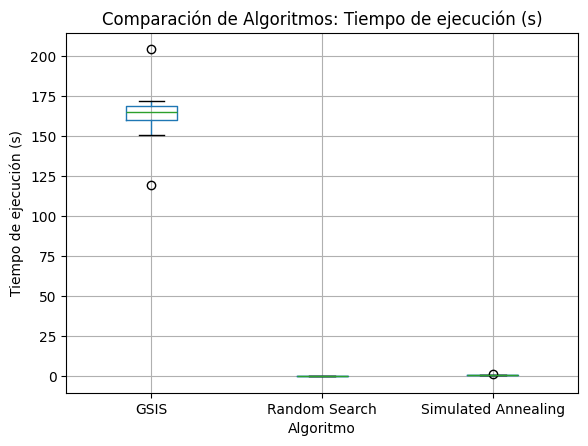

<Figure size 800x600 with 0 Axes>

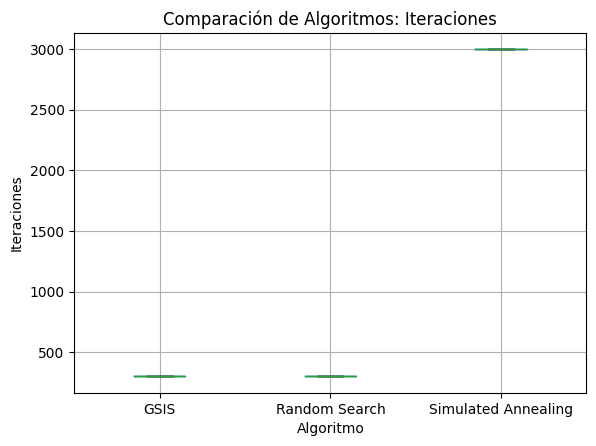

<Figure size 800x600 with 0 Axes>

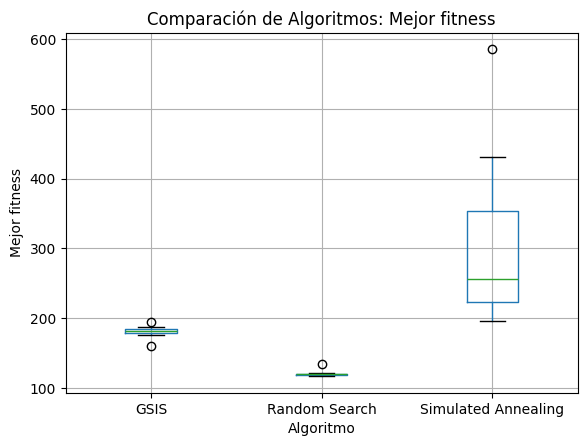

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos desde el archivo CSV
archivo_csv = "P1results.csv"
df = pd.read_csv(archivo_csv)

# Filtrar los DataFrames por algoritmo
df_gsis = df[df['Algoritmo'] == 'GSIS'].copy()
df_sa = df[df['Algoritmo'] == 'SA'].copy()
df_rs = df[df['Algoritmo'] == 'RS'].copy()

# Verifica las columnas disponibles
print("Columnas disponibles en el DataFrame:", df.columns)

# Seleccionar métricas a comparar
metricas = ["Tiempo de ejecución (s)", "Iteraciones", "Mejor fitness"]

# Generar los diagramas comparativos
generar_diagramas_bigotes_comparativos(df_gsis, df_sa, df_rs, metricas)
